In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
import h5py as h5
import hdf5plugin
from matplotlib.colors import LogNorm
import skbeam.core.correlation as corr
import scipy.ndimage as ndimage
import time

from lmfit.models import GaussianModel, ConstantModel

from importlib import reload
import lsco_ana as lsco
reload(lsco)
import xpcs_ana as xpcs
reload(xpcs)

<module 'xpcs_ana' from 'C:\\Users\\espov\\Documents\\Science_projects\\LSCO\\LSCO_DESY\\xpcs_ana.py'>

In [2]:
plt.style.use('dark_background')
#matplotlib.rcParams.keys()
plt.rcParams['figure.figsize'] = (10, 6)
plt.rc('font', size=12)
length = 8
width = 1.5
plt.rcParams['xtick.major.size'] = length
plt.rcParams['ytick.major.size'] = length
plt.rcParams['xtick.major.width'] = width
plt.rcParams['ytick.major.width'] = width

Image number of interest: 50
Center of Mass of the image : 301, 300


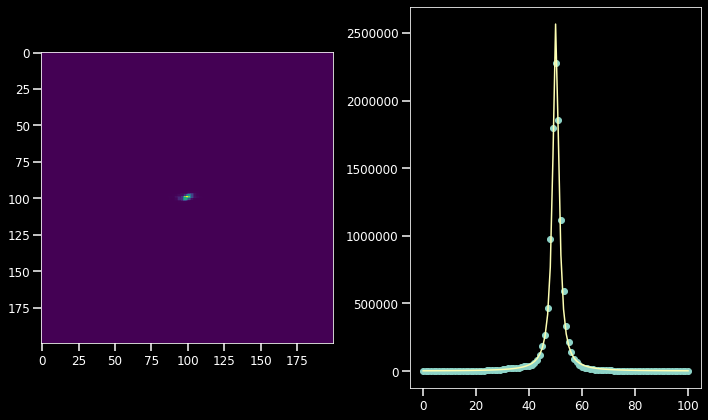

(1800, 600, 600)


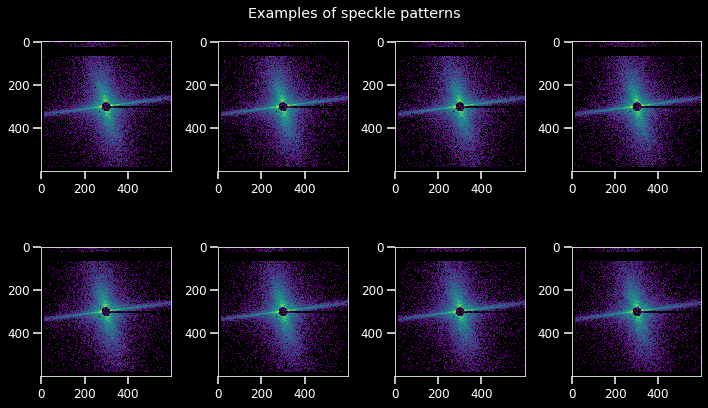

In [3]:
""" LOAD DATA """

data_dir = Path(r'C:\Users\espov\Desktop\DESY')
r_th = 24
r_time = 25
drow1, drow2, dcol1, dcol2 = 300,300,300,300  # region of interest size

# Analyze th scan: find peak center
feiger, fmaster, fbatchinfo = lsco.get_file_name(r_th, data_dir)
feiger = h5.File(feiger, 'r')
fmaster = h5.File(fmaster, 'r')
eiger = np.asarray(feiger['entry']['data']['data'])
qoi,com = lsco.centering_ls(eiger, drow1, drow2, dcol1, dcol2)

# Analyze time series
feiger, fmaster, fbatchinfo = lsco.get_file_name(r_time, data_dir)
feiger = h5.File(feiger, 'r')
fmaster = h5.File(fmaster, 'r')
eiger = np.asarray(feiger['entry']['data']['data'][:,qoi[0]:qoi[1], qoi[2]:qoi[3]])
print(eiger.shape)
eiger[eiger>1e7] = 0
fig, axs = plt.subplots(nrows=2, ncols=4)
fig.suptitle('Examples of speckle patterns')
for ii, ax in enumerate(axs.ravel()):
    ax.imshow(eiger[100*ii], norm=LogNorm())
plt.tight_layout()
plt.show()

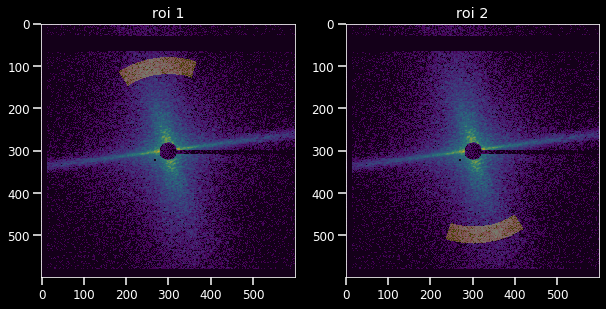

In [4]:
rad, phi = xpcs.polarCoord(eiger[0].shape, com)
r0, dr, phi0, dphi, tilt = 200., 20., 90., 25, 7.5
roi1 = lsco.roi_lsco(eiger[0], com, r0, dr, phi0, dphi, tilt)
r0, dr, phi0, dphi, tilt = 200., 20., -90., 25, 7.5
roi2 = lsco.roi_lsco(eiger[0], com, r0, dr, phi0, dphi, tilt)

fig, ax = plt.subplots(ncols=2)
ax[0].imshow(eiger[0], norm=LogNorm())
ax[0].imshow(roi1, alpha=0.3)
ax[0].set_title('roi 1')
ax[1].imshow(eiger[0], norm=LogNorm())
ax[1].imshow(roi2, alpha=0.3)
ax[1].set_title('roi 2')
plt.show()

# (i) Correct non-uniform illumination

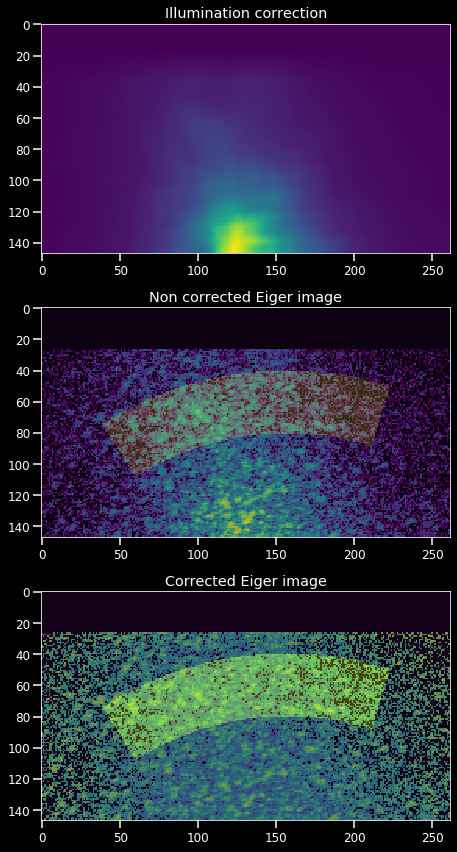

In [5]:
ksize = 20
if ksize is None:
    extend = 10
else:
    extend=2*ksize
    
eiger_corr, roi, bp = xpcs.correct_illumination(eiger, roi1, kernel_size=ksize)

fig, ax = plt.subplots(nrows=3, figsize=(8,12))
ax[0].set_title('Illumination correction')
# ax[0].imshow(bp, norm=LogNorm())
ax[0].imshow(bp)
# ax[0].imshow(roi, alpha=0.2)

ax[1].set_title('Non corrected Eiger image')
ax[1].imshow(xpcs.box_to_roi_extend(eiger[1000],roi1, extend=extend)[0], norm=LogNorm())
ax[1].imshow(roi, alpha=0.2)

ax[2].set_title('Corrected Eiger image')
ax[2].imshow(eiger_corr[1000], norm=LogNorm())
ax[2].imshow(roi, alpha=0.3)

plt.tight_layout()
plt.show()

# Noise correction

160.0


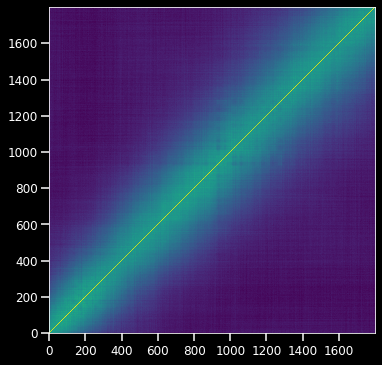

In [6]:
# Get c_I(t,tau)
num_levels = 1
num_bufs = eiger_corr.shape[0]
num_frames = eiger_corr.shape[0]

tic = time.time()
twoTime_roi = corr.two_time_corr(roi, eiger_corr, num_frames, num_bufs, num_levels=1)
print(np.round(time.time()-tic))

c_I = twoTime_roi.g2[0]-1
plt.imshow(c_I, origin='lower')

In [10]:
var_cI = np.var(c_I)

## c_I variance as a function or roi size

In [14]:
r0, dr, phi0, dphis, tilt = 200., 20., 90., [25,20,15,10,5], 7.5

c_I = []
n_pix = []
for ii, dphi in enumerate(dphis):
    # define ROI
    roi = lsco.roi_lsco(eiger[0], com, r0, dr, phi0, dphi, tilt)
    n_pix.append(roi.sum())
    
    # correct illumination
    eiger_corr, roi, bp = xpcs.correct_illumination(eiger, roi, kernel_size=ksize)
    
    # compute the two-time correlation function
    num_levels = 1
    num_bufs = eiger_corr.shape[0]
    num_frames = eiger_corr.shape[0]

    tic = time.time()
    twoTime_roi = corr.two_time_corr(roi, eiger_corr, num_frames, num_bufs, num_levels=1)
    print(np.round(time.time()-tic))
    
    c_I.append(twoTime_roi.g2[0]-1)

176.0
160.0
149.0
114.0
52.0


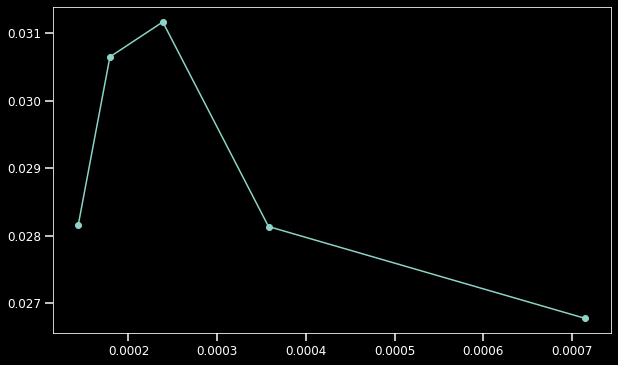

In [20]:
n_pix = np.asarray(n_pix)
c_I = np.asarray(c_I)
var_cI = np.var(c_I, axis=(1,2))
fig, ax = plt.subplots()
ax.plot(1/n_pix, var_cI, '-o')

9.905310250875859


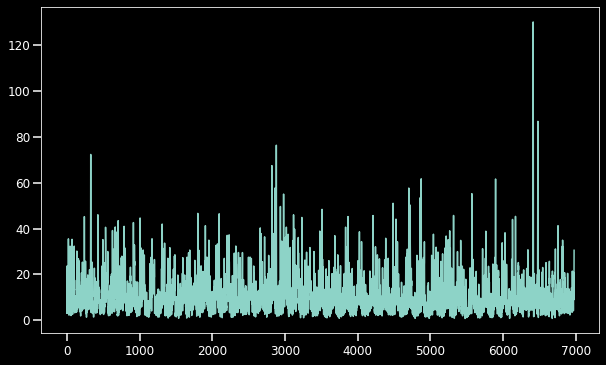

In [7]:
var_I = np.var(eiger_corr[:,roi], axis=0) # var_I = sigma_I**2
# plt.imshow(var_I)
print(var_I.mean())
plt.plot(var_I)
plt.show()

In [8]:
speckles = eiger_corr
one_time_corr = np.zeros(speckles.shape[0]-1)
G2 = np.zeros(speckles.shape[0]-1)
norm = np.zeros(speckles.shape[0]-1)

# Loop over all the pairs of tau = 1,2,...N
tic = time.time()
for ii in range(speckles.shape[0]-1):
    tau = ii+1
    G2[ii] = np.mean(speckles[0:-1-tau:1, roi]*speckles[tau:-1:1, roi])
    norm[ii] = np.mean(speckles[0:-1-tau:1, roi])*np.mean(speckles[tau:-1:1, roi])
    one_time_corr[ii] = G2[ii]/norm[ii]
toc = time.time()
print((toc-tic)/60)

KeyboardInterrupt: 